In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:

from SGanalysis.SGobject import SGobject

In [3]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'


# roi_2
# roi_2
roi_name = 'roi_2'

In [4]:
# First time, I ran this to create the pickle file...

# # Create an instance of SGobject
# sg_obj = SGobject()

# # Convert a TIFF image to polygons and store them in a GeoDataFrame
# print("Running mask_to_objects...")
# sg_obj.mask_to_objects(f'{filepath}{roi_name}/segmentations/segmentation_1_nuclei.tiff')

# spot_file = f'{filepath}{roi_name}/exports/decode_20240314_withcoordinates.csv'

# sg_obj.load_points(spot_file)

# # sg_obj.dilate_objects(10)
# sg_obj.create_cell_gene_table()

# # with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
# #     pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'wb') as f:
#     pickle.dump(sg_obj,f)


## Later instances, use the pickle file to avoid needing to 

with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# sg_obj 

In [8]:
# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
#     pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
    # pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

In [5]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23614/755052625.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index


In [6]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

# df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

No filtering available or applied.


In [7]:
sg_obj.gdf

,object_id,nucleus
0,35,"POLYGON ((9279.000 2.000, 9349.000 3.000, 9356..."
1,34,"POLYGON ((6437.000 2.000, 6520.000 2.000, 6527..."
2,29,"POLYGON ((24636.000 0.000, 24762.000 0.000, 24..."
3,11,"POLYGON ((11474.000 0.000, 11542.000 0.000, 11..."
4,15,"POLYGON ((14595.000 0.000, 14678.000 2.000, 14..."
...,...,...
16371,16364,"POLYGON ((19896.000 35571.000, 19914.000 35571..."
16372,16375,"POLYGON ((20380.000 35592.000, 20408.000 35596..."
16373,16361,"POLYGON ((22881.000 35565.000, 22904.000 35566..."
16374,16357,"POLYGON ((24819.000 35560.000, 24840.000 35560..."


In [9]:
df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names
0,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,[],0,
1,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,[],0,
10,13.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,"[bc_024, bc_043]",2,bc_024-bc_043
100,126.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100,[],0,
1000,989.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1000,"[bc_001, bc_035, bc_062]",3,bc_001-bc_035-bc_062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9991.0,6.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,18.0,...,30.0,0.0,0.0,0.0,5.0,0.0,9995,"[bc_011, bc_013, bc_047, bc_048, bc_086, bc_09...",7,bc_011-bc_013-bc_047-bc_048-bc_086-bc_091-bc_095
9996,9993.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,11.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9996,[bc_014],1,bc_014
9997,10003.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9997,"[bc_002, bc_020, bc_033, bc_041, bc_058, bc_078]",6,bc_002-bc_020-bc_033-bc_041-bc_058-bc_078
9998,9988.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9998,"[bc_025, bc_035]",2,bc_025-bc_035


In [10]:
out_path = f'{filepath}{roi_name}/exports/'

In [11]:
## traditional barcode calling (using cutoff of 3)

df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] >= cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

# df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)

# df.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast{cutoff}.csv')

total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])


cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes']
# for col in :
#     adata_genes.obs[col] = df[col]


No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23614/2757054561.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names
object_id,,,,,,,,,,,,,,,,,,,,,
1.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,[],0,
2.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,79.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,[],0,
3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,22.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,"[bc_035, bc_068]",2,bc_035-bc_068
4.0,7.0,0.0,1.0,0.0,4.0,0.0,0.0,7.0,57.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[bc_035, bc_068]",2,bc_035-bc_068
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,"[bc_044, bc_074]",2,bc_044-bc_074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16372.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16372.0,[bc_035],1,bc_035
16373.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16373.0,[],0,
16374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16374.0,[],0,


In [13]:
cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes']

adata_genes.obs = df[cols]


cluster_name_cutoff = 3

obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

# adata_genes.obs.to_csv(f'{out_path}/cell_by_gene_matrix__withbarcodes_clustering_{total_bc_threshold}bcs_{threshold}thresh.csv')

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1.0, 2.0, 3.0, 4.0, 5.0]

    Inferred to be: floating

  value_idx = self._prep_dim_index(value.index, attr)


0 ['bc_071']
1 ['bc_085', 'bc_091']
2 ['bc_020', 'bc_025', 'bc_066', 'bc_096']
3 ['bc_066', 'bc_082']
4 ['bc_009', 'bc_014', 'bc_070', 'bc_083']
5 ['bc_018', 'bc_065']
6 ['bc_002', 'bc_012', 'bc_057', 'bc_066', 'bc_082']
7 ['bc_012', 'bc_024', 'bc_086']
8 ['bc_028', 'bc_060', 'bc_070', 'bc_074', 'bc_079', 'bc_094']
9 ['bc_024', 'bc_037', 'bc_057', 'bc_063', 'bc_070', 'bc_076', 'bc_083', 'bc_084', 'bc_087']
10 ['bc_013', 'bc_036', 'bc_043', 'bc_045', 'bc_059', 'bc_060', 'bc_083']
11 ['bc_015', 'bc_024', 'bc_066']
12 ['bc_020', 'bc_025', 'bc_035', 'bc_038', 'bc_045', 'bc_082', 'bc_084']
13 ['bc_003', 'bc_020', 'bc_029', 'bc_040', 'bc_053', 'bc_067', 'bc_088']
14 ['bc_001']
15 ['bc_001', 'bc_004', 'bc_035', 'bc_045', 'bc_074', 'bc_095']
16 ['bc_014', 'bc_017', 'bc_020', 'bc_033']
17 ['bc_001', 'bc_047', 'bc_058']
18 ['bc_025', 'bc_033', 'bc_044']
19 ['bc_015', 'bc_033']
20 ['bc_008', 'bc_028', 'bc_035', 'bc_039', 'bc_057', 'bc_070', 'bc_095']
21 ['bc_027']
22 ['bc_003', 'bc_008', 'bc_014'

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23614/840227469.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23614/840227469.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for

In [14]:
# find number of cells with at least cutoff spots per barcode

# cutoff = 1
cutoff = 2
# cutoff = 3

n_cells = {}

for bc in ['bc_{:03d}'.format(i) for i in range(1,97)]:
    n_cells[bc] = len(df[df[bc]>cutoff][bc].values)


In [15]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values

In [16]:
sg_obj.gdf.geometry.bounds

,minx,miny,maxx,maxy
0,9272.0,2.0,9356.0,19.0
1,6422.0,2.0,6527.0,27.0
2,24626.0,0.0,24765.0,33.0
3,11464.0,0.0,11563.0,42.0
4,14555.0,0.0,14684.0,38.0
...,...,...,...,...
16371,19805.0,35571.0,19974.0,35609.0
16372,20337.0,35592.0,20419.0,35609.0
16373,22808.0,35565.0,22939.0,35609.0
16374,24729.0,35560.0,24896.0,35609.0


In [17]:
sg_obj.gdf['object_id']

sg_obj.gdf['object_id_str'] = sg_obj.gdf['object_id'].astype(int)
df['object_id'] = [int(float(x)) for x in df['cell_id'].values]

In [18]:
sg_obj.gdf

,object_id,nucleus,nucleus_centroid,object_id_str
0,35,"POLYGON ((9279.000 2.000, 9349.000 3.000, 9356...",POINT (9310.387 8.913),35
1,34,"POLYGON ((6437.000 2.000, 6520.000 2.000, 6527...",POINT (6475.859 12.348),34
2,29,"POLYGON ((24636.000 0.000, 24762.000 0.000, 24...",POINT (24695.071 14.397),29
3,11,"POLYGON ((11474.000 0.000, 11542.000 0.000, 11...",POINT (11512.465 18.850),11
4,15,"POLYGON ((14595.000 0.000, 14678.000 2.000, 14...",POINT (14620.955 16.886),15
...,...,...,...,...
16371,16364,"POLYGON ((19896.000 35571.000, 19914.000 35571...",POINT (19899.601 35594.028),16364
16372,16375,"POLYGON ((20380.000 35592.000, 20408.000 35596...",POINT (20379.341 35601.878),16375
16373,16361,"POLYGON ((22881.000 35565.000, 22904.000 35566...",POINT (22879.829 35591.004),16361
16374,16357,"POLYGON ((24819.000 35560.000, 24840.000 35560...",POINT (24816.056 35588.584),16357


In [35]:
adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 10].head(20)

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
37.0,37.0,11,bc_006-bc_015-bc_025-bc_030-bc_039-bc_041-bc_0...,"[bc_006, bc_015, bc_025, bc_030, bc_039, bc_04...",555.0,11.0,"[bc_015, bc_025, bc_030, bc_039, bc_041, bc_05...",bc_015-bc_025-bc_030-bc_039-bc_041-bc_056-bc_0...
39.0,39.0,10,bc_008-bc_028-bc_043-bc_048-bc_057-bc_070-bc_0...,"[bc_008, bc_028, bc_043, bc_048, bc_057, bc_07...",3287.0,10.0,"[bc_008, bc_028, bc_043, bc_048, bc_057, bc_07...",bc_008-bc_028-bc_043-bc_048-bc_057-bc_070-bc_0...
43.0,43.0,13,bc_003-bc_025-bc_035-bc_040-bc_041-bc_043-bc_0...,"[bc_003, bc_025, bc_035, bc_040, bc_041, bc_04...",2723.0,10.0,"[bc_003, bc_025, bc_040, bc_041, bc_043, bc_04...",bc_003-bc_025-bc_040-bc_041-bc_043-bc_044-bc_0...
124.0,124.0,14,bc_003-bc_006-bc_011-bc_020-bc_022-bc_052-bc_0...,"[bc_003, bc_006, bc_011, bc_020, bc_022, bc_05...",1883.0,13.0,"[bc_003, bc_006, bc_011, bc_022, bc_052, bc_05...",bc_003-bc_006-bc_011-bc_022-bc_052-bc_053-bc_0...
140.0,140.0,13,bc_015-bc_025-bc_030-bc_039-bc_041-bc_052-bc_0...,"[bc_015, bc_025, bc_030, bc_039, bc_041, bc_05...",555.0,11.0,"[bc_015, bc_025, bc_030, bc_039, bc_041, bc_05...",bc_015-bc_025-bc_030-bc_039-bc_041-bc_056-bc_0...
273.0,273.0,11,bc_013-bc_024-bc_028-bc_039-bc_040-bc_052-bc_0...,"[bc_013, bc_024, bc_028, bc_039, bc_040, bc_05...",255.0,10.0,"[bc_024, bc_028, bc_035, bc_039, bc_040, bc_06...",bc_024-bc_028-bc_035-bc_039-bc_040-bc_060-bc_0...
375.0,375.0,11,bc_014-bc_028-bc_035-bc_039-bc_040-bc_052-bc_0...,"[bc_014, bc_028, bc_035, bc_039, bc_040, bc_05...",255.0,10.0,"[bc_024, bc_028, bc_035, bc_039, bc_040, bc_06...",bc_024-bc_028-bc_035-bc_039-bc_040-bc_060-bc_0...
381.0,381.0,1,bc_070,[bc_070],255.0,10.0,"[bc_024, bc_028, bc_035, bc_039, bc_040, bc_06...",bc_024-bc_028-bc_035-bc_039-bc_040-bc_060-bc_0...
413.0,413.0,11,bc_015-bc_022-bc_034-bc_037-bc_038-bc_048-bc_0...,"[bc_015, bc_022, bc_034, bc_037, bc_038, bc_04...",3023.0,10.0,"[bc_022, bc_034, bc_037, bc_038, bc_048, bc_05...",bc_022-bc_034-bc_037-bc_038-bc_048-bc_059-bc_0...


In [ ]:
adata_genes.obs[adata_genes.obs['bc_cluster_n_bcs'] >= 10]

In [20]:
clusterdf[df['n_called_barcodes']>=10].va.ue

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id
object_id,,,,,,,,,,,,,,,,,,,,,
37.0,14.0,0.0,0.0,0.0,4.0,0.0,0.0,9.0,64.0,2.0,...,0.0,0.0,0.0,0.0,0.0,37.0,"[bc_006, bc_015, bc_025, bc_030, bc_039, bc_04...",11,bc_006-bc_015-bc_025-bc_030-bc_039-bc_041-bc_0...,37
39.0,3.0,0.0,0.0,0.0,11.0,0.0,0.0,33.0,45.0,3.0,...,0.0,7.0,0.0,0.0,6.0,39.0,"[bc_008, bc_028, bc_043, bc_048, bc_057, bc_07...",10,bc_008-bc_028-bc_043-bc_048-bc_057-bc_070-bc_0...,39
43.0,12.0,1.0,6.0,0.0,5.0,0.0,0.0,29.0,160.0,5.0,...,0.0,1.0,0.0,0.0,0.0,43.0,"[bc_003, bc_025, bc_035, bc_040, bc_041, bc_04...",13,bc_003-bc_025-bc_035-bc_040-bc_041-bc_043-bc_0...,43
60.0,8.0,0.0,2.0,0.0,4.0,0.0,0.0,22.0,177.0,3.0,...,0.0,0.0,0.0,0.0,0.0,60.0,"[bc_001, bc_019, bc_025, bc_028, bc_038, bc_04...",10,bc_001-bc_019-bc_025-bc_028-bc_038-bc_043-bc_0...,60
80.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,30.0,66.0,1.0,...,0.0,0.0,0.0,0.0,1.0,80.0,"[bc_014, bc_015, bc_025, bc_039, bc_041, bc_04...",10,bc_014-bc_015-bc_025-bc_039-bc_041-bc_046-bc_0...,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15976.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,14.0,37.0,0.0,...,0.0,0.0,10.0,0.0,0.0,15976.0,"[bc_005, bc_008, bc_009, bc_022, bc_024, bc_02...",11,bc_005-bc_008-bc_009-bc_022-bc_024-bc_025-bc_0...,15976
15998.0,15.0,0.0,0.0,0.0,9.0,0.0,0.0,31.0,95.0,1.0,...,0.0,0.0,0.0,5.0,9.0,15998.0,"[bc_007, bc_008, bc_010, bc_013, bc_033, bc_05...",12,bc_007-bc_008-bc_010-bc_013-bc_033-bc_050-bc_0...,15998
16042.0,14.0,0.0,0.0,0.0,22.0,0.0,0.0,47.0,165.0,5.0,...,0.0,36.0,0.0,0.0,0.0,16042.0,"[bc_011, bc_013, bc_019, bc_024, bc_029, bc_03...",12,bc_011-bc_013-bc_019-bc_024-bc_029-bc_033-bc_0...,16042


In [30]:
## default highly variable gene identification (seurat) is applied to log(1+x) counts
## this normalization 
sc.pp.log1p(adata_genes)
# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')

In [31]:
df[(df['IFIT2']>4) & (df['n_called_barcodes'] >2 ) ][['object_id','cell_id','IFIT2','barcode_names']]

,object_id,cell_id,IFIT2,barcode_names
object_id,,,,
185.0,185,185.0,8.0,bc_039-bc_060-bc_081
1137.0,1137,1137.0,18.0,bc_057-bc_085-bc_092-bc_095
1144.0,1144,1144.0,5.0,bc_025-bc_039-bc_067-bc_076
2455.0,2455,2455.0,23.0,bc_015-bc_039-bc_056-bc_073-bc_085-bc_091-bc_092
2698.0,2698,2698.0,6.0,bc_017-bc_038-bc_041
4270.0,4270,4270.0,7.0,bc_057-bc_066-bc_075-bc_076-bc_092
4309.0,4309,4309.0,10.0,bc_006-bc_057-bc_066-bc_074-bc_075-bc_076-bc_092
4346.0,4346,4346.0,18.0,bc_006-bc_057-bc_092
4388.0,4388,4388.0,17.0,bc_066-bc_075-bc_076


['bc_003', 'bc_004', 'bc_005', 'bc_008', 'bc_009', 'bc_013', 'bc_019', 'bc_021', 'bc_024', 'bc_025', 'bc_027', 'bc_028', 'bc_030', 'bc_035', 'bc_039', 'bc_040', 'bc_041', 'bc_043', 'bc_044', 'bc_045', 'bc_047', 'bc_048', 'bc_052', 'bc_058', 'bc_059', 'bc_060', 'bc_062', 'bc_066', 'bc_067', 'bc_068', 'bc_070', 'bc_073', 'bc_076', 'bc_080', 'bc_081', 'bc_083', 'bc_084', 'bc_085', 'bc_086', 'bc_091', 'bc_092', 'bc_093', 'bc_095']
['bc_009-bc_035-bc_068' 'bc_070' ''
 'bc_003-bc_025-bc_035-bc_040-bc_041-bc_043-bc_044-bc_045-bc_048-bc_068-bc_073-bc_076-bc_081'
 'bc_019-bc_068-bc_083-bc_095' 'bc_070'
 'bc_021-bc_028-bc_048-bc_062-bc_067-bc_080-bc_085'
 'bc_021-bc_028-bc_048-bc_059-bc_062-bc_080-bc_085'
 'bc_009-bc_027-bc_035-bc_091' 'bc_004-bc_052-bc_081' ''
 'bc_039-bc_060-bc_081' 'bc_041' '' '' '' 'bc_030-bc_047-bc_081'
 'bc_004-bc_052-bc_081' 'bc_039-bc_058-bc_060-bc_081-bc_086' 'bc_009'
 'bc_030-bc_047' 'bc_030-bc_047' 'bc_030-bc_047'
 'bc_005-bc_030-bc_047-bc_081-bc_092-bc_093' 'bc_013-b

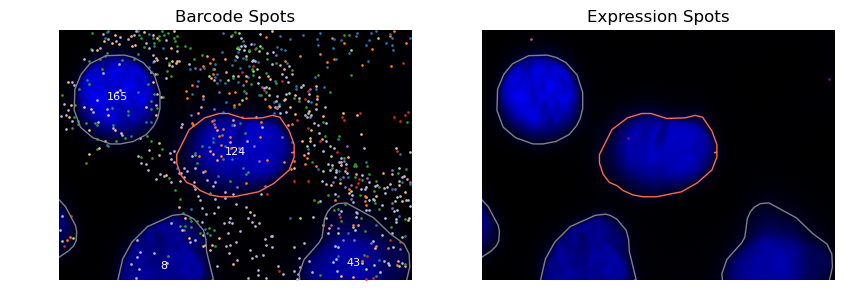

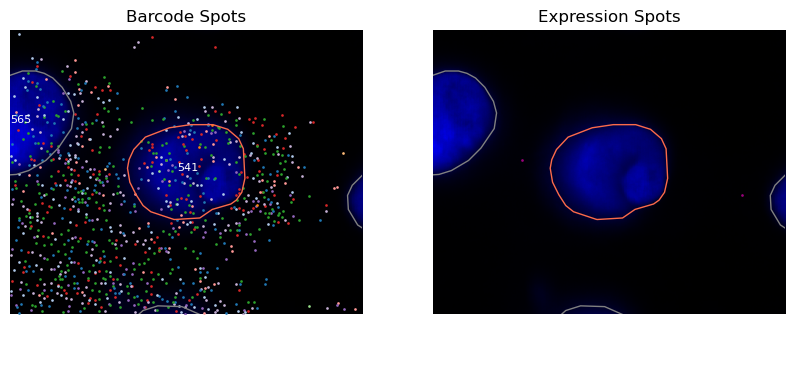

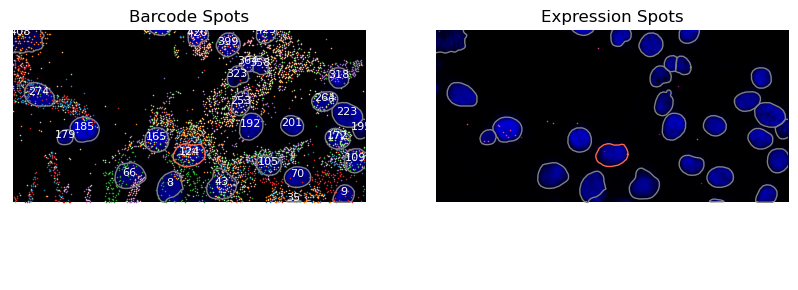

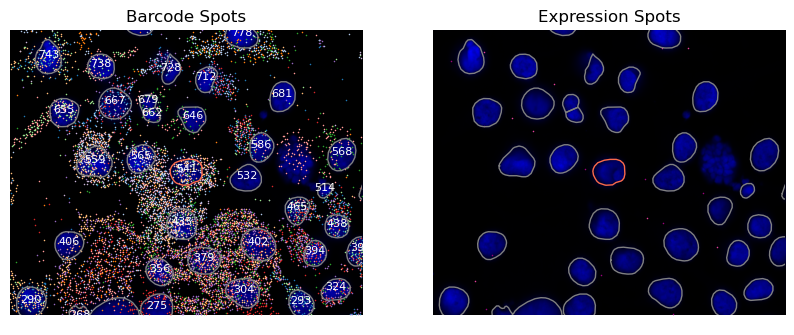

In [36]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

# scale = 2

# dictionary of marker sizes based on the scale
marker_sizes = {2:15,10:5}

for object_id in ['124','541']:
  for scale in [2,10]:
      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

      barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
      barcode_names = list(np.unique(barcode_names))
      print(barcode_names)

      print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

    #   color_map = {
    # 'bc_013':sns.color_palette('Reds',4)[0],
    # 'bc_023':sns.color_palette('Reds',4)[1],
    # 'bc_035':sns.color_palette('Reds',4)[2],
                  
    # 'bc_061':sns.color_palette('Greens',4)[0],
    # 'bc_073':sns.color_palette('Greens',4)[1],
    # 'bc_088':sns.color_palette('Greens',4)[2],

    # 'bc_053':sns.color_palette('Purples',3)[0],
    # 'bc_086':sns.color_palette('Purples',3)[1],
    # 'bc_022':sns.color_palette('Greys',2)[1]
    #   }

      for barcode in sg_obj.obs[]
      color_map = {}


      counter = 0
      for gene in barcode_names:
          if gene not in color_map.keys():
              color_map[gene] = sns.color_palette('Greys',10)[counter%10]
              counter+=1


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      plt.figure(figsize=(10,10))

      ax = plt.subplot(1,2,1)

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

      # sisters = ['4957','4946','4900','4961']

      tools.plot_polygons_and_points(sg_obj,[object_id],
                                    # sisters,
                                    #  region['object_id'].values,
                                    id_field='object_id',
                                    gene_names=barcode_names,
                                    annotate=False,image_scale=scale,single_mode=False,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,
                                    exterior_marker='.',marker_size=marker_sizes[scale],ax=ax,
                                    show_image=True,image_path=image_path,
                                    annotate_cells=True
                                    )

      plt.title('Barcode Spots')
      
      plt.axis('off')

      ax = plt.subplot(1,2,2)
      
      cluster_genes = {
          # 0:['MLANA'],
                      #  1:['VEGFA','NRG1','BIRC3'],
                      #  2:['COL1A1','COL5A2','BGN'],
                      #  3:['MMP11','BMP2','ROR2'],
                      #  4:['NANOG','TYR','ERBB3'],
                      #  5: ['TYR',],
                      6: ['OASL','IFIT2'],
                      #  7: ['MMP1','SERPINE1','NT5E'],
                      }
      
      cluster_colors = {
                        # 0:'Greys',
                        0:'dark:#D3D3D3',
                      #   1:'Reds',
                      #   2:'Greens',
                      #   3:'Oranges',
                      #   4:'Greys',
                        # 5:'Greys',
                        # 6:'Oranges',
                        # 6:'light:#ffbf00'
                        # 6:'Reds',
                        6:'RdPu',

                      #   7:'Purples'
                        }
      
      gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

      color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      tools.plot_polygons_and_points(sg_obj,
                                    #  region['object_id'].values,
                                    [object_id],
                                    gene_names=gene_names,
                                    annotate=False,image_scale=scale,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,single_mode=False,
                                    exterior_marker='.',marker_size=marker_sizes[scale],ax=ax,
                                    show_image=True,image_path=image_path,
                                    )
      
      plt.title('Expression Spots')
      
      plt.axis('off')

      # plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression_scale{scale}.pdf',bbox_inches='tight')
      # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

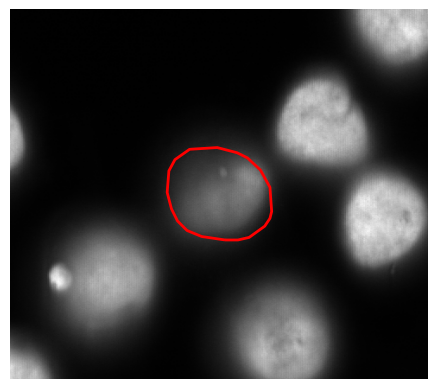

In [34]:
image_path = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/rawData/roi_2/hyb_1_aligned.tiff'

tools.show_neighborhood(sg_obj,object_id,image_path,image_scale=3)

In [37]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id
object_id,,,,,,,,,,,,,,,,,,,,,
1.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,[],0,,1
2.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,79.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,[],0,,2
3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,22.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,"[bc_035, bc_068]",2,bc_035-bc_068,3
4.0,7.0,0.0,1.0,0.0,4.0,0.0,0.0,7.0,57.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,"[bc_035, bc_068]",2,bc_035-bc_068,4
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,1.0,...,0.0,0.0,0.0,0.0,0.0,5.0,"[bc_044, bc_074]",2,bc_044-bc_074,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16372.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16372.0,[bc_035],1,bc_035,16372
16373.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16373.0,[],0,,16373
16374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16374.0,[],0,,16374


['bc_001', 'bc_004', 'bc_007', 'bc_013', 'bc_017', 'bc_020', 'bc_022', 'bc_023', 'bc_024', 'bc_025', 'bc_027', 'bc_028', 'bc_029', 'bc_030', 'bc_035', 'bc_039', 'bc_040', 'bc_041', 'bc_043', 'bc_047', 'bc_048', 'bc_049', 'bc_052', 'bc_053', 'bc_056', 'bc_059', 'bc_060', 'bc_061', 'bc_064', 'bc_068', 'bc_073', 'bc_074', 'bc_076', 'bc_077', 'bc_079', 'bc_081', 'bc_085', 'bc_086', 'bc_087', 'bc_088', 'bc_091']
['bc_001-bc_048-bc_087' 'bc_025-bc_085' 'bc_025'
 'bc_001-bc_024-bc_048-bc_087' 'bc_025-bc_085'
 'bc_017-bc_022-bc_030-bc_039-bc_043-bc_047-bc_049-bc_052-bc_060-bc_077-bc_081'
 '' 'bc_022' 'bc_022-bc_028-bc_041-bc_052' 'bc_013-bc_023-bc_035' 'bc_091'
 'bc_013-bc_023-bc_035-bc_061-bc_073-bc_088' 'bc_013-bc_023-bc_035'
 'bc_013-bc_022-bc_053-bc_086-bc_088' 'bc_061-bc_073-bc_088'
 'bc_013-bc_022-bc_053-bc_086' 'bc_020-bc_059' 'bc_020-bc_059' 'bc_022'
 'bc_020-bc_059'
 'bc_007-bc_024-bc_029-bc_040-bc_056-bc_064-bc_068-bc_076-bc_079-bc_085-bc_091'
 'bc_027-bc_086' 'bc_035-bc_079-bc_091' 

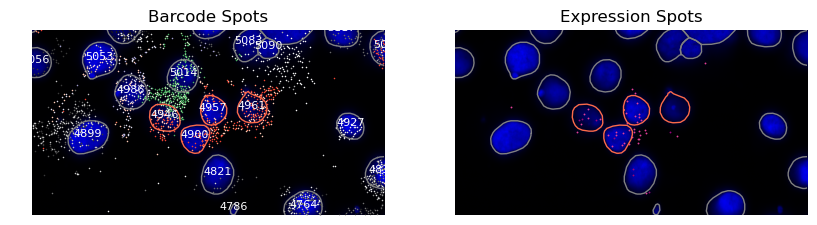

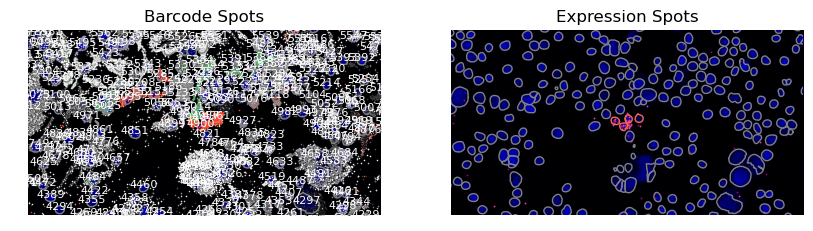

In [41]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scale = 2

# dictionary of marker sizes based on the scale
marker_sizes = {2:5,10:1}

for scale in [2,10]:

  for object_id in ['4957']:

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

      barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id',literal_eval=False)
      barcode_names = list(np.unique(barcode_names))
      print(barcode_names)

      print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

      color_map = {
    'bc_013':sns.color_palette('Reds',4)[0],
    'bc_023':sns.color_palette('Reds',4)[1],
    'bc_035':sns.color_palette('Reds',4)[2],
                  
    'bc_061':sns.color_palette('Greens',4)[0],
    'bc_073':sns.color_palette('Greens',4)[1],
    'bc_088':sns.color_palette('Greens',4)[2],

    'bc_053':sns.color_palette('Purples',3)[0],
    'bc_086':sns.color_palette('Purples',3)[1],
    'bc_022':sns.color_palette('Greys',2)[1]
      }


      counter = 0
      for gene in barcode_names:
          if gene not in color_map.keys():
              color_map[gene] = sns.color_palette('Greys',10)[counter%10]
              counter+=1


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      plt.figure(figsize=(10,10))

      ax = plt.subplot(1,2,1)

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

      sisters = ['4957','4946','4900','4961']

      tools.plot_polygons_and_points(sg_obj,
                                    sisters,
                                    #  region['object_id'].values,
                                    id_field='object_id',
                                    gene_names=barcode_names,
                                    annotate=False,image_scale=scale,single_mode=False,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,
                                    exterior_marker='.',marker_size=5,ax=ax,
                                    show_image=True,image_path=image_path,
                                    annotate_cells=True
                                    )

      plt.title('Barcode Spots')
      
      plt.axis('off')

      ax = plt.subplot(1,2,2)
      # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
      # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
      #              'MITF':sns.color_palette('Blues',3)[1],
      #              'IGFBP7':sns.color_palette('PuRd',3)[2],
      #              'COL1A1':'g',
      #              'IFIT2':'gold',
      #              'MMP1':'orange',
      #              'MMP11':'orange',
      #              'NANOG':'k',
      #              'BMP2':'k',
      #              'MLANA':sns.color_palette('Blues',3)[2]}
      
      cluster_genes = {
          # 0:['MLANA'],
                      #  1:['VEGFA','NRG1','BIRC3'],
                      #  2:['COL1A1','COL5A2','BGN'],
                      #  3:['MMP11','BMP2','ROR2'],
                      #  4:['NANOG','TYR','ERBB3'],
                      #  5: ['TYR',],
                      6: ['OASL','IFIT2'],
                      #  7: ['MMP1','SERPINE1','NT5E'],
                      }
      
      cluster_colors = {
                        # 0:'Greys',
                        0:'dark:#D3D3D3',
                      #   1:'Reds',
                      #   2:'Greens',
                      #   3:'Oranges',
                      #   4:'Greys',
                        # 5:'Greys',
                        # 6:'Oranges',
                        # 6:'light:#ffbf00'
                        # 6:'Reds',
                        6:'RdPu',

                      #   7:'Purples'
                        }
      
      gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

      color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      tools.plot_polygons_and_points(sg_obj,
                                    #  region['object_id'].values,
                                    sisters,
                                    gene_names=gene_names,
                                    annotate=False,image_scale=scale,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,single_mode=False,
                                    exterior_marker='.',marker_size=7,ax=ax,
                                    show_image=True,image_path=image_path
                                    )
      
      plt.title('Expression Spots')
      
      plt.axis('off')

      # plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression_scale{scale}.pdf',bbox_inches='tight')
      # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

[]
['bc_001-bc_048-bc_087' 'bc_025-bc_085' 'bc_025'
 'bc_001-bc_024-bc_048-bc_087' 'bc_025-bc_085'
 'bc_017-bc_022-bc_030-bc_039-bc_043-bc_047-bc_049-bc_052-bc_060-bc_077-bc_081'
 '' 'bc_022' 'bc_022-bc_028-bc_041-bc_052' 'bc_013-bc_023-bc_035' 'bc_091'
 'bc_013-bc_023-bc_035-bc_061-bc_073-bc_088' 'bc_013-bc_023-bc_035'
 'bc_013-bc_022-bc_053-bc_086-bc_088' 'bc_061-bc_073-bc_088'
 'bc_013-bc_022-bc_053-bc_086' 'bc_020-bc_059' 'bc_020-bc_059' 'bc_022'
 'bc_020-bc_059'
 'bc_007-bc_024-bc_029-bc_040-bc_056-bc_064-bc_068-bc_076-bc_079-bc_085-bc_091'
 'bc_027-bc_086' 'bc_035-bc_079-bc_091' 'bc_086' 'bc_091' 'bc_027-bc_086'
 'bc_007-bc_029-bc_040-bc_064-bc_085-bc_091'
 'bc_007-bc_013-bc_022-bc_023-bc_035-bc_079-bc_091' 'bc_004-bc_022'
 'bc_024-bc_056' 'bc_004-bc_073-bc_074-bc_088']
[('bc_013', '#fdcab5'), ('bc_023', '#fc8a6a'), ('bc_035', '#f14432'), ('bc_061', '#d3eecd'), ('bc_073', '#98d594'), ('bc_088', '#4bb062'), ('bc_053', '#dadaeb'), ('bc_086', '#b84203'), ('bc_022', '#686868'), ('bc_

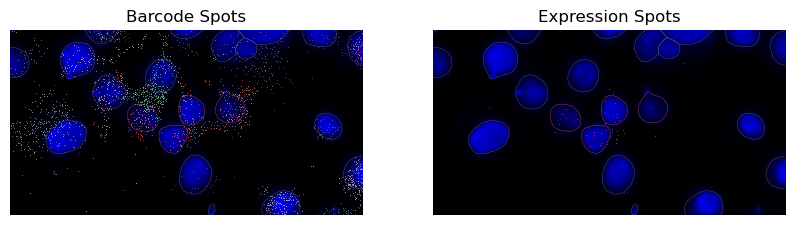

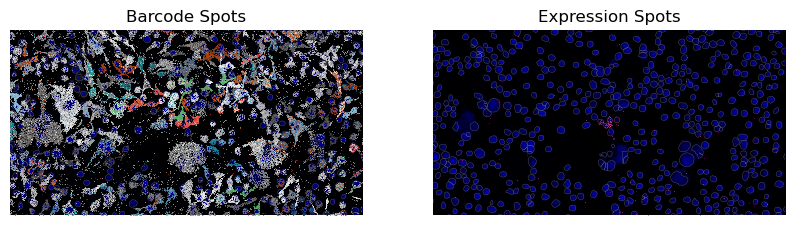

In [42]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scale = 15
scale = 2

# dictionary of marker sizes based on the scale
marker_sizes = {2:5,10:1}

for scale in [2,15]:
  for object_id in ['4957']:

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

      barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
      barcode_names = list(np.unique(barcode_names))

      
      print([name for name in barcode_names if name.count('_') >2])

      print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

      color_map = {
    'bc_013':sns.color_palette('Reds',4)[0],
    'bc_023':sns.color_palette('Reds',4)[1],
    'bc_035':sns.color_palette('Reds',4)[2],
                  
    'bc_061':sns.color_palette('Greens',4)[0],
    'bc_073':sns.color_palette('Greens',4)[1],
    'bc_088':sns.color_palette('Greens',4)[2],

    'bc_053':sns.color_palette('Purples',3)[0],
    'bc_086':sns.color_palette('Purples',3)[1],
    'bc_022':sns.color_palette('Greys',2)[1],

    'bc_028':sns.color_palette('Blues',6)[1],
    'bc_041':sns.color_palette('Blues',6)[2],
    'bc_044':sns.color_palette('Blues',6)[3],
    'bc_045':sns.color_palette('Blues',6)[4],
    'bc_070':sns.color_palette('Blues',6)[5],

    #   'bc_045':sns.color_palette('Blues',6)[4],
    # 'bc_070':sns.color_palette('Blues',6)[5],

      'bc_025':sns.color_palette('PuBuGn',3)[1],
    'bc_085':sns.color_palette('PuBuGn',3)[2],

        'bc_027':sns.color_palette('YlOrBr',4)[2],
    'bc_086':sns.color_palette('YlOrBr',4)[3],

      }


      counter = 0
      for gene in barcode_names:
          if gene not in color_map.keys():
              color_map[gene] = sns.color_palette('Greys',10)[counter%10]
              counter+=1


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      plt.figure(figsize=(10,10))

      ax = plt.subplot(1,2,1)

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

      sisters = ['4957','4946','4900','4961']

      tools.plot_polygons_and_points(sg_obj,
                                    sisters,
                                    #  region['object_id'].values,
                                    id_field='object_id',
                                    gene_names=barcode_names,
                                    annotate=False,image_scale=scale,single_mode=False,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,
                                    exterior_marker='.',marker_size=1,ax=ax,lw=0.2,
                                    show_image=True,image_path=image_path,
                                    annotate_cells=False
                                    )

      plt.title('Barcode Spots')
      
      plt.axis('off')

      ax = plt.subplot(1,2,2)
      # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
      # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
      #              'MITF':sns.color_palette('Blues',3)[1],
      #              'IGFBP7':sns.color_palette('PuRd',3)[2],
      #              'COL1A1':'g',
      #              'IFIT2':'gold',
      #              'MMP1':'orange',
      #              'MMP11':'orange',
      #              'NANOG':'k',
      #              'BMP2':'k',
      #              'MLANA':sns.color_palette('Blues',3)[2]}
      
      cluster_genes = {
          # 0:['MLANA'],
                      #  1:['VEGFA','NRG1','BIRC3'],
                      #  2:['COL1A1','COL5A2','BGN'],
                      #  3:['MMP11','BMP2','ROR2'],
                      #  4:['NANOG','TYR','ERBB3'],
                      #  5: ['TYR',],
                      6: ['OASL','IFIT2'],
                      #  7: ['MMP1','SERPINE1','NT5E'],
                      }
      
      cluster_colors = {
                        # 0:'Greys',
                        0:'dark:#D3D3D3',
                      #   1:'Reds',
                      #   2:'Greens',
                      #   3:'Oranges',
                      #   4:'Greys',
                        # 5:'Greys',
                        # 6:'Oranges',
                        # 6:'light:#ffbf00'
                        # 6:'Reds',
                        6:'RdPu',

                      #   7:'Purples'
                        }
      
      gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

      color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      tools.plot_polygons_and_points(sg_obj,
                                    #  region['object_id'].values,
                                    sisters,
                                    gene_names=gene_names,
                                    annotate=False,image_scale=scale,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,single_mode=False,
                                    exterior_marker='.',marker_size=1,ax=ax,lw=0.2,
                                    show_image=True,image_path=image_path
                                    )
      
      plt.title('Expression Spots')
      
      plt.axis('off')

      plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression_big{scale}.pdf',bbox_inches='tight')
      # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

object_id
1.0            1
2.0            2
3.0            3
4.0            4
5.0            5
           ...  
16372.0    16372
16373.0    16373
16374.0    16374
16375.0    16375
16376.0    16376
Name: object_id, Length: 16376, dtype: int64

In [98]:
region['object_id'].values

array(['4530', '4632', '4662', '4698', '4729', '4786', '4764', '4821',
       '4900', '4899', '4927', '4946', '4961', '4986', '5014', '5053',
       '5090', '5083', '5117', '5142', '5133', '5126', '5186', '5216',
       '5221', '5219', '5229', '5248', '5262', '5293', '5296'],
      dtype=object)

In [97]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,,,,,,,,,,,,,,
1.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,1.0,[],0,,1,NaN,NaN,NaN,NaN
2.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,79.0,1.0,...,0.0,2.0,[],0,,2,NaN,NaN,NaN,NaN
3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,22.0,0.0,...,0.0,3.0,"[bc_035, bc_068]",2,bc_035-bc_068,3,409.0,2.0,"[bc_035, bc_068]",bc_035-bc_068
4.0,7.0,0.0,1.0,0.0,4.0,0.0,0.0,7.0,57.0,0.0,...,0.0,4.0,"[bc_035, bc_068]",2,bc_035-bc_068,4,409.0,2.0,"[bc_035, bc_068]",bc_035-bc_068
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,1.0,...,0.0,5.0,"[bc_044, bc_074]",2,bc_044-bc_074,5,276.0,2.0,"[bc_044, bc_074]",bc_044-bc_074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16372.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,16372.0,[bc_035],1,bc_035,16372,NaN,NaN,NaN,NaN
16373.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,...,0.0,16373.0,[],0,,16373,NaN,NaN,NaN,NaN
16374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16374.0,[],0,,16374,NaN,NaN,NaN,NaN


In [106]:
df[df['object_id'].isin(region['object_id_str'].values)]['bc_cluster_bc_names']

object_id
4530.0                                        bc_001-bc_087
4632.0                                        bc_025-bc_085
4662.0                                               bc_025
4698.0                                 bc_024-bc_033-bc_087
4729.0                                        bc_025-bc_085
4764.0    bc_017-bc_022-bc_030-bc_039-bc_043-bc_047-bc_0...
4786.0                                                  NaN
4821.0                                               bc_022
4899.0                   bc_028-bc_041-bc_044-bc_045-bc_070
4900.0                                 bc_013-bc_023-bc_035
4927.0                                               bc_091
4946.0                                 bc_013-bc_023-bc_035
4961.0                                 bc_013-bc_023-bc_035
4986.0                          bc_013-bc_022-bc_053-bc_086
5014.0                          bc_004-bc_061-bc_073-bc_088
5053.0                          bc_013-bc_022-bc_053-bc_086
5083.0                        

In [107]:
np.unique([bc for bc in df[df['object_id'].isin(region['object_id_str'].values)]['bc_cluster_bc_names'] if bc != np.nan],return_counts=True)

(array(['bc_001-bc_087', 'bc_004-bc_061-bc_073-bc_088',
        'bc_004-bc_073-bc_074-bc_088',
        'bc_007-bc_013-bc_022-bc_023-bc_035-bc_079-bc_091',
        'bc_007-bc_029-bc_040-bc_064-bc_079-bc_085-bc_091',
        'bc_013-bc_022-bc_053-bc_086', 'bc_013-bc_023-bc_035',
        'bc_017-bc_022-bc_030-bc_039-bc_043-bc_047-bc_049-bc_052-bc_060-bc_081',
        'bc_020-bc_059', 'bc_022', 'bc_024-bc_033-bc_087',
        'bc_024-bc_056-bc_064-bc_068-bc_076', 'bc_025', 'bc_025-bc_085',
        'bc_027-bc_086', 'bc_028-bc_041-bc_044-bc_045-bc_070', 'bc_059',
        'bc_091', 'nan'], dtype='<U69'),
 array([1, 1, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 3]))

In [94]:
# add bc_cluster info to df based on object_id from adata_genes.obs
df['bc_cluster'] = [adata_genes.obs.loc[obj_id]['bc_cluster'] if obj_id in adata_genes.obs.index else np.nan for obj_id in df['object_id']]
df['bc_cluster_n_bcs'] = [adata_genes.obs.loc[obj_id]['bc_cluster_n_bcs'] if obj_id in adata_genes.obs.index else np.nan for obj_id in df['object_id']]
df['bc_cluster_found_bcs'] = [adata_genes.obs.loc[obj_id]['bc_cluster_found_bcs'] if obj_id in adata_genes.obs.index else np.nan for obj_id in df['object_id']]
df['bc_cluster_bc_names'] = [adata_genes.obs.loc[obj_id]['bc_cluster_bc_names'] if obj_id in adata_genes.obs.index else np.nan for obj_id in df['object_id']]

In [268]:
adata_genes.obs

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
1.0,1.0,0,,[],NaN,NaN,NaN,NaN
2.0,2.0,0,,[],NaN,NaN,NaN,NaN
3.0,3.0,2,bc_035-bc_068,"[bc_035, bc_068]",409.0,2.0,"[bc_035, bc_068]",bc_035-bc_068
4.0,4.0,2,bc_035-bc_068,"[bc_035, bc_068]",409.0,2.0,"[bc_035, bc_068]",bc_035-bc_068
5.0,5.0,2,bc_044-bc_074,"[bc_044, bc_074]",276.0,2.0,"[bc_044, bc_074]",bc_044-bc_074
...,...,...,...,...,...,...,...,...
16372.0,16372.0,1,bc_035,[bc_035],NaN,NaN,NaN,NaN
16373.0,16373.0,0,,[],NaN,NaN,NaN,NaN
16374.0,16374.0,0,,[],NaN,NaN,NaN,NaN
16375.0,16375.0,0,,[],NaN,NaN,NaN,NaN


In [93]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id,bc_cluster
object_id,,,,,,,,,,,,,,,,,,,,,
1.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,0.0,1.0,[],0,,1,NaN
2.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,79.0,1.0,...,0.0,0.0,0.0,0.0,2.0,[],0,,2,NaN
3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,22.0,0.0,...,0.0,1.0,0.0,0.0,3.0,"[bc_035, bc_068]",2,bc_035-bc_068,3,409.0
4.0,7.0,0.0,1.0,0.0,4.0,0.0,0.0,7.0,57.0,0.0,...,0.0,0.0,0.0,0.0,4.0,"[bc_035, bc_068]",2,bc_035-bc_068,4,409.0
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,1.0,...,0.0,0.0,0.0,0.0,5.0,"[bc_044, bc_074]",2,bc_044-bc_074,5,276.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16372.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,16372.0,[bc_035],1,bc_035,16372,NaN
16373.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,...,0.0,0.0,0.0,0.0,16373.0,[],0,,16373,NaN
16374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16374.0,[],0,,16374,NaN


In [91]:
# get subset of adata genes corresponding to the region

adata_genes_region = adata_genes[adata_genes.obs['cell_id'].isin(region['object_id_str'].values)]

AssertionError: Don’t call _normalize_index with non-categorical/string names

In [270]:
# calculate the average of each gene in each group (e.g. spatial location or clone )

def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)


In [271]:
adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

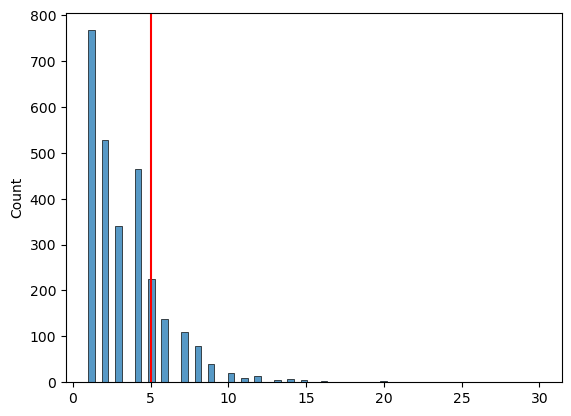

In [273]:
n_bcs_per_cluster_cutoff = 3
n_cells_per_cluster_cutoff = 5

confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

In [275]:
real_delta  = group_delta_mean(confident_clusters,'bc_cluster')
perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=1000)
# perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=100)

In [236]:
pd.DataFrame(perm_deltas)

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,TRPM1,TYR,VCAM1,VEGFA,VEGFC,VGF,WNT5A,YAP1,ZEB1,ZEB2
0,1.455344,0.297063,0.512990,0.346574,1.777341,0.277259,0.346574,2.110219,1.934066,1.567672,...,0.680239,2.031316,0.277259,1.271222,0.554518,0.399649,0.529676,1.473542,0.577623,1.599263
1,1.705032,0.358352,0.496981,0.415888,2.134522,0.277259,0.414151,2.122397,1.839569,1.697759,...,0.774240,1.738503,0.415888,1.051499,0.554518,0.358352,0.496981,1.705032,0.577623,1.403300
2,1.762569,0.255966,0.566866,0.277259,1.893717,0.358352,0.415888,1.793622,2.152178,1.460650,...,0.760725,1.924087,0.358352,1.126138,0.554518,0.358352,0.454008,1.492922,0.496981,1.514523
3,1.626298,0.231049,0.512990,0.346574,1.984501,0.231049,0.454008,1.812900,1.588042,1.512016,...,0.865493,1.668065,0.358352,1.383145,0.554518,0.358352,0.496981,1.508866,0.599146,1.589035
4,1.632320,0.277259,0.460517,0.462098,2.192256,0.231049,0.415888,1.739605,1.874085,1.454480,...,0.774240,1.614066,0.415888,1.294778,0.599146,0.358352,0.496981,1.490938,0.635611,1.529939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.461955,0.277259,0.599146,0.415888,1.934513,0.298627,0.358352,1.687377,1.737808,1.615975,...,0.721040,1.655407,0.415888,1.315850,0.462098,0.358352,0.554518,1.433408,0.454008,1.517516
96,1.889303,0.277259,0.599146,0.415888,1.880171,0.277259,0.439445,1.725389,2.118552,1.535573,...,0.709973,2.097373,0.277259,1.315850,0.578074,0.618209,0.529676,1.611032,0.439445,1.620204
97,1.673871,0.231049,0.599146,0.354987,1.982291,0.415888,0.358352,1.892251,1.976781,1.493474,...,0.912870,2.218474,0.496981,1.144489,0.737776,0.299737,0.496981,1.406915,0.774240,1.514501
98,1.751721,0.231049,0.496981,0.297063,2.214295,0.277259,0.358352,1.780073,1.675681,1.595831,...,0.717941,1.916553,0.415888,1.048349,0.529676,0.298627,0.439445,1.687110,0.554518,1.409254


In [237]:
p_vals = calculate_empirical_p_values(real_delta,pd.DataFrame(perm_deltas))

Text(0, 0.5, 'Number of genes')

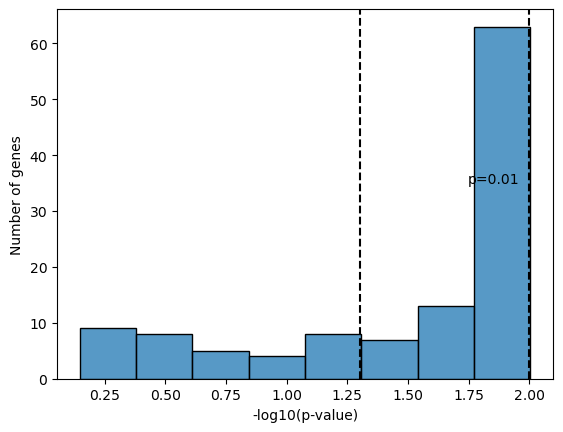

In [254]:
sns.histplot(-np.log10(p_vals))

plt.axvline(-np.log10(0.01),color='k',linestyle='--')
plt.text(-np.log10(0.01+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

In [261]:
ratio.sort_values(ascending=False)[:10]

BGN         2.884977
SFRP4       2.793572
NOTCH4      2.375089
BIRC3       2.298165
SERPINE1    2.249191
MMP1        2.096956
SFRP1       1.949752
VEGFC       1.872442
SPARC       1.796566
PDGFA       1.771262
dtype: float64

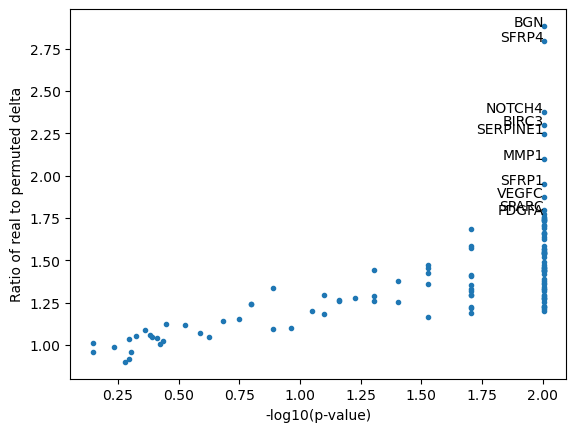

In [264]:
# calculate ratio of real data to average from the permutations

ratio = real_delta/np.mean(perm_deltas,axis=0)

plt.scatter(-np.log10(p_vals),ratio,marker='.')

plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# annotate top genes
for gene in ratio.sort_values(ascending=False)[:10].index:
    plt.text(-np.log10(p_vals[gene]),ratio[gene],gene,ha='right')

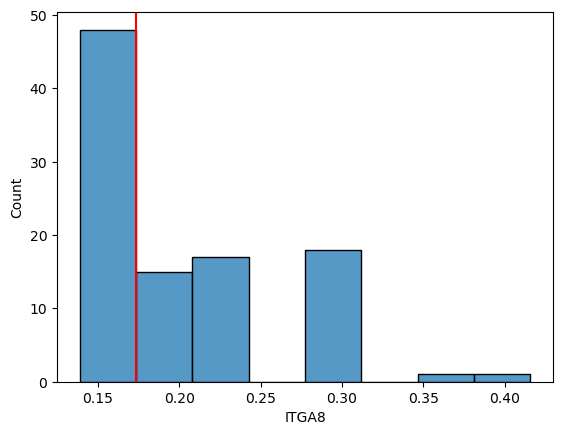

In [251]:
gene = 'VEGFA'
gene = 'MITF'
gene = 'AXL'
gene = 'ITGA8'
# gene = 'SFRP1'
# gene = 'BGN'

sns.histplot(pd.DataFrame(perm_deltas)[gene])
plt.axvline(real_delta[gene],color='r')

In [226]:
pd.DataFrame(perm_deltas)[gene].values

array([2.30258512, 2.30258512, 2.30258512, 2.19722462, 2.48490667,
       1.60943794, 1.9459101 , 2.19722462, 2.19722462, 1.9459101 ,
       2.48490667, 2.48490667, 2.30258512, 1.9459101 , 1.9459101 ,
       1.9459101 , 1.79175949, 2.48490667, 1.79175949, 2.19722462,
       1.60943794, 1.79175949, 2.07944155, 2.30258512, 2.48490667,
       2.19722462, 1.79175949, 1.79175949, 1.79175949, 1.9459101 ,
       2.48490667, 1.60943794, 2.19722462, 2.30258512, 1.9459101 ,
       1.60943794, 1.9459101 , 2.48490667, 2.19722462, 2.30258512,
       2.48490667, 2.19722462, 1.79175949, 1.60943794, 2.07944155,
       2.48490667, 1.9459101 , 2.48490667, 1.79175949, 2.19722462,
       2.19722462, 1.9459101 , 2.19722462, 1.60943794, 1.60943794,
       1.9459101 , 1.60943794, 1.60943794, 1.79175949, 1.79175949,
       2.48490667, 2.19722462, 1.9459101 , 2.48490667, 1.9459101 ,
       1.79175949, 2.19722462, 2.30258512, 2.48490667, 1.79175949,
       2.07944155, 1.60943794, 2.30258512, 1.79175949, 2.07944

In [278]:
ring_annotated = pd.read_csv('/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/processed_data/ring_anotated_cell_by_gene.csv',index_col=0)

In [284]:
adata_genes.obs['cell_id']

1.0            1.0
2.0            2.0
3.0            3.0
4.0            4.0
5.0            5.0
            ...   
16372.0    16372.0
16373.0    16373.0
16374.0    16374.0
16375.0    16375.0
16376.0    16376.0
Name: cell_id, Length: 16376, dtype: float64

In [314]:
adata_genes_ring = sc.AnnData(ring_annotated[[col for col in ring_annotated.columns if col in gene_cols]])

adata_genes_ring

# assign erosion ring to each cell in obs according to the ring_annoted file
adata_genes_ring.obs['erosion_ring'] = ring_annotated['Erosion_Ring'].values

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_52894/3226337975.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_annotated[[col for col in ring_annotated.columns if col in gene_cols]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [312]:
ring_annotated['Erosion_Ring']

0         1
1         1
2         1
3         1
4         1
         ..
38295    25
38296    25
38297    25
38298    25
38299    25
Name: Erosion_Ring, Length: 38300, dtype: int64

In [316]:
adata_genes_ring.obs['erosion_ring']

0         1
1         1
2         1
3         1
4         1
         ..
38295    25
38296    25
38297    25
38298    25
38299    25
Name: erosion_ring, Length: 38300, dtype: int64

In [317]:
real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=100)

In [330]:
p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))

In [369]:
p_vals_ring.sort_values()

AKT1                  0.009901
ROR2                  0.009901
ROR1                  0.009901
RIGI                  0.009901
RGS2                  0.009901
                        ...   
ITGA8                 0.059406
MMP11                 0.099010
NOTCH3                0.099010
ENSMUSG00000071361    0.504950
MMP1                  0.722772
Length: 116, dtype: float64

Text(0.5, 1.0, 'Erosion analysis')

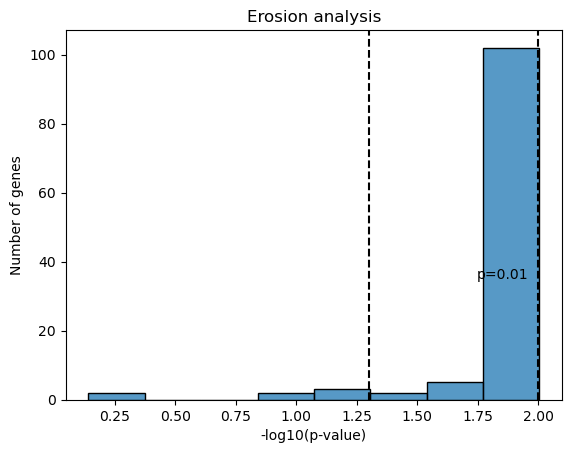

In [331]:
sns.histplot(-np.log10(p_vals_ring))

plt.axvline(-np.log10(0.01),color='k',linestyle='--')
plt.text(-np.log10(0.01+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')
plt.title('Erosion analysis')

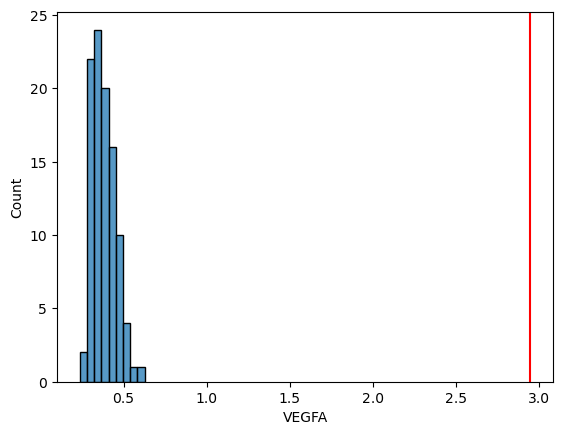

In [332]:
gene = 'VEGFA'
# gene = 'MITF'
# gene = 'AXL'
# gene = 'ITGA8'
# gene = 'SFRP1'
# gene = 'BGN'

sns.histplot(pd.DataFrame(perm_deltas_ring)[gene])
plt.axvline(real_delta_ring[gene],color='r')

In [333]:
-np.log10(p_vals_ring)

AKT1     2.004321
AXL      2.004321
BGN      2.004321
BIRC3    1.703291
BIRC5    2.004321
           ...   
VGF      1.226170
WNT5A    1.527200
YAP1     2.004321
ZEB1     2.004321
ZEB2     2.004321
Length: 116, dtype: float64

In [334]:
ratio_ring

AKT1     7.408610
AXL      1.979277
BGN      3.727127
BIRC3    1.841771
BIRC5    7.735972
           ...   
VGF      1.364473
WNT5A    1.607042
YAP1     4.603213
ZEB1     2.696143
ZEB2     4.481457
Length: 116, dtype: float64

In [335]:
perm_deltas_ring

[AKT1     0.178100
 AXL      0.036164
 BGN      0.660201
 BIRC3    0.015922
 BIRC5    0.205293
            ...   
 VGF      0.177945
 WNT5A    0.016852
 YAP1     0.131317
 ZEB1     0.029316
 ZEB2     0.095323
 Length: 116, dtype: float64,
 AKT1     0.183925
 AXL      0.040895
 BGN      0.575329
 BIRC3    0.014042
 BIRC5    0.194790
            ...   
 VGF      0.272129
 WNT5A    0.016729
 YAP1     0.112465
 ZEB1     0.024282
 ZEB2     0.111153
 Length: 116, dtype: float64,
 AKT1     0.171224
 AXL      0.052619
 BGN      0.657703
 BIRC3    0.027469
 BIRC5    0.269250
            ...   
 VGF      0.198688
 WNT5A    0.022038
 YAP1     0.068944
 ZEB1     0.033182
 ZEB2     0.112889
 Length: 116, dtype: float64,
 AKT1     0.147573
 AXL      0.054863
 BGN      0.857836
 BIRC3    0.019412
 BIRC5    0.239489
            ...   
 VGF      0.318710
 WNT5A    0.015553
 YAP1     0.146298
 ZEB1     0.035580
 ZEB2     0.129193
 Length: 116, dtype: float64,
 AKT1     0.149065
 AXL      0.039032
 BGN  

In [336]:
real_delta_ring

AKT1     1.410759
AXL      0.087355
BGN      2.492845
BIRC3    0.039420
BIRC5    1.582413
           ...   
VGF      0.280769
WNT5A    0.034427
YAP1     0.470725
ZEB1     0.085203
ZEB2     0.633783
Length: 116, dtype: float64

In [337]:
perm_deltas_ring

[AKT1     0.178100
 AXL      0.036164
 BGN      0.660201
 BIRC3    0.015922
 BIRC5    0.205293
            ...   
 VGF      0.177945
 WNT5A    0.016852
 YAP1     0.131317
 ZEB1     0.029316
 ZEB2     0.095323
 Length: 116, dtype: float64,
 AKT1     0.183925
 AXL      0.040895
 BGN      0.575329
 BIRC3    0.014042
 BIRC5    0.194790
            ...   
 VGF      0.272129
 WNT5A    0.016729
 YAP1     0.112465
 ZEB1     0.024282
 ZEB2     0.111153
 Length: 116, dtype: float64,
 AKT1     0.171224
 AXL      0.052619
 BGN      0.657703
 BIRC3    0.027469
 BIRC5    0.269250
            ...   
 VGF      0.198688
 WNT5A    0.022038
 YAP1     0.068944
 ZEB1     0.033182
 ZEB2     0.112889
 Length: 116, dtype: float64,
 AKT1     0.147573
 AXL      0.054863
 BGN      0.857836
 BIRC3    0.019412
 BIRC5    0.239489
            ...   
 VGF      0.318710
 WNT5A    0.015553
 YAP1     0.146298
 ZEB1     0.035580
 ZEB2     0.129193
 Length: 116, dtype: float64,
 AKT1     0.149065
 AXL      0.039032
 BGN  

In [384]:
ratio_ring.sort_values(ascending=True)[:10]

MMP1                  0.843512
ENSMUSG00000071361    0.947825
MMP11                 1.310275
ITGA8                 1.343116
NOTCH3                1.353575
VGF                   1.364473
LMOD1                 1.424195
SFRP4                 1.502903
BMP2                  1.534228
KIT                   1.573702
dtype: float64

In [341]:
ratio_ring.sort_values(ascending=False)[:10]

MITF      9.487149
COL9A3    8.533023
SPARC     8.436704
MYBL2     8.220553
ERBB3     8.151426
VEGFA     7.739409
BIRC5     7.735972
L1CAM     7.676322
CTNNB1    7.485276
TYR       7.463089
dtype: float64

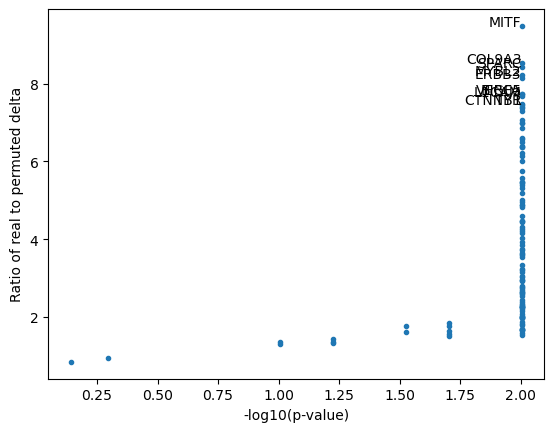

In [340]:
# calculate ratio of real data to average from the permutations

ratio_ring = real_delta_ring/np.mean(perm_deltas_ring,axis=0)

plt.scatter(-np.log10(p_vals_ring),ratio_ring,marker='.')

plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# annotate top genes
for gene in ratio_ring.sort_values(ascending=False)[:10].index:
    plt.text(-np.log10(p_vals_ring[gene]),ratio_ring[gene],gene,ha='right')

In [344]:
from adjustText import adjust_text

([Text(1.5736641986053705, 9.718674831977378, 'MITF'),
  Text(1.4800760306727523, 8.944625087435305, 'COL9A3'),
  Text(1.8524061283432918, 8.796855140162782, 'SPARC'),
  Text(1.2248652988470456, 8.760780768992513, 'MYBL2'),
  Text(1.179601213137177, 8.305776842926123, 'ERBB3'),
  Text(1.2173020764139941, 7.6372725818477845, 'VEGFA'),
  Text(1.4508738575823197, 8.078142039987009, 'BIRC5'),
  Text(1.6321387961119418, 7.547696144315487, 'L1CAM'),
  Text(1.2087686329434693, 7.2023001792682715, 'CTNNB1'),
  Text(1.4158182312934582, 7.283013040259749, 'TYR'),
  Text(2.9123739500989845, 3.958652725238028, 'BGN'),
  Text(2.846661112025072, 1.7344286539968126, 'SFRP4'),
  Text(2.278995850378299, 1.5349877036387745, 'NOTCH4'),
  Text(2.1941868427089943, 2.0452578259513605, 'BIRC3'),
  Text(2.3554955059292038, 2.5913933713825377, 'SERPINE1'),
  Text(2.0057463793886994, 0.6634363025286917, 'MMP1'),
  Text(2.0034180285113923, 2.7004404126848254, 'SFRP1'),
  Text(1.9324086463939485, 1.89561910832194

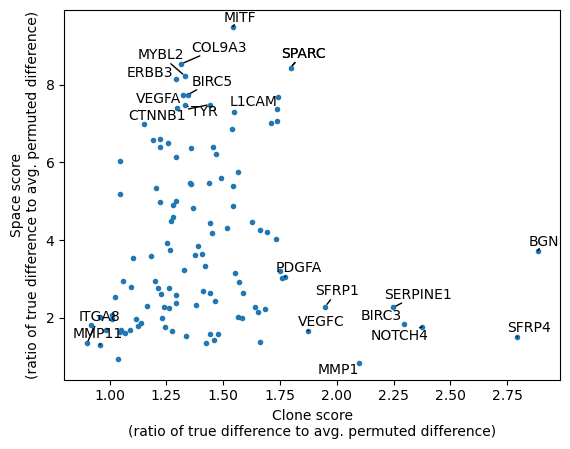

In [386]:
# plot ratio for clone and rings, only plotting genes present in both sets
common_genes = [gene for gene in ratio_ring.index if gene in ratio.index]

plt.scatter(ratio[common_genes],ratio_ring[common_genes],marker='.')
plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

# annotate top 5 genes for each using adjust_text

texts = []
for gene in ratio_ring.sort_values(ascending=False)[:10].index:
    texts.append(plt.text(ratio[gene],ratio_ring[gene],gene,ha='right'))


for gene in ratio.sort_values(ascending=False)[:10].index:
    texts.append(plt.text(ratio[gene],ratio_ring[gene],gene,ha='right'))

for gene in ratio.sort_values(ascending=True)[:10].index:
    if gene in ratio_ring.sort_values(ascending=True)[:10].index:
        if gene != 'ENSMUSG00000071361':
            texts.append(plt.text(ratio[gene],ratio_ring[gene],gene,ha='right'))

adjust_text(texts,arrowprops=dict(arrowstyle='-',color='k'))




In [375]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:
sns.histplot(sorted(means.loc[gene])/np.sum(means.loc[gene]))

NameError: name 'sns' is not defined

In [1]:
means =grouped_obs_mean(confident_clusters,'bc_cluster')

genes_to_show = ['VEGFA',
                 'MITF',
                 'SPARC',
                 'SFRP1',
                 'BGN',
                 'SFRP4',
                 'MMP11',
                 'ITGA8',
                 'MMP1'
                 ]

colors = {'VEGFA':sns.color_palette('Blues',3)[0],
          'MITF':sns.color_palette('Blues',3)[1],
          'SPARC':sns.color_palette('Blues',3)[2],
          'SFRP1':sns.color_palette('Reds',3)[0],
          'BGN':sns.color_palette('Reds',3)[1],
          'SFRP4':sns.color_palette('Reds',3)[2],
          'MMP11':sns.color_palette('Greys',3)[0],
          'ITGA8':sns.color_palette('Greys',3)[1],
          'MMP1':'k'
          }

for gene in genes_to_show:
    plt.plot(sorted(means.loc[gene])/np.sum(means.loc[gene]),label=gene,color=colors[gene])

plt.xlabel('Clone (sorted by avg. expression)')
plt.ylabel('Proportion of overall expression to clone')
plt.yscale('log')
plt.legend()

plt.figure()
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    plt.plot(means_ring.loc[gene]/np.sum(means_ring.loc[gene]),label=gene,color=colors[gene])

plt.legend()
plt.xlabel('Ring')
plt.ylabel('Avg. Expression')

plt.figure()
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    plt.plot(moving_average(means_ring.loc[gene]/np.sum(means_ring.loc[gene]),3),label=gene,color=colors[gene])

plt.legend()
plt.xlabel('Ring')
plt.ylabel('Avg. Expression')




NameError: name 'grouped_obs_mean' is not defined

In [ ]:
# gene_of_interest = 'SFRP1'
# how = 'fraction_90'

# print((gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False))
# # clusters_of_interest = [int(x) for x in (gene_by_bc_cluster_proportion.loc[gene_of_interest ])[gene_by_bc_cluster_proportion.loc[gene_of_interest ] > 0.05].index]

# top_to_plot = 1
# threshold = 0.02

# props = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values

# top_to_plot = min([sum(props>threshold),top_to_plot])

# clusters_of_interest = [int(x) for x in (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).index[:top_to_plot]]
# proportions_of_interest = (gene_by_cluster_proportion_dict[how].loc[gene_of_interest ]).sort_values(ascending=False).values[:top_to_plot]

how = 'p_val+FC'
# gene_of_interest = 'FGFR1'
gene_of_interest = 'SFRP1'
gene_of_interest = 'FGF1'
cluster_of_interest = 512



cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)
print(cluster_of_interest,len(cluster_cells),cluster_cells)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

sg_obj.gdf['object_id'] = sg_obj.gdf.index

gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')

print(np.unique(gene_names))

fig = plt.figure(figsize=(10,10))

vmin = 0
vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])

ax = fig.add_subplot(221)
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
                            annotate=False,image_scale=0.5,label=f'in cluster {cluster_of_interest}',
                            focal_outline_color='k',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.5,
                            exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} barcodes')

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Blues', legend=False,vmin=vmin,vmax=vmax,ax=ax)

rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(224)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues',
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('Spots per cell')

ax = fig.add_subplot(222)

gene_names = [gene_of_interest]

# gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

# tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=gene_names,central_polygon_ix=central_ix,
#                             annotate=False,image_scale=0.5,label=f'in cluster {clusters_of_interest[0]}',
#                             focal_outline_color='r',other_outline_color='gray',
#                             interior_marker='.',single_mode=False,lw=0.5,
#                             exterior_marker='.',marker_size=2,ax=ax)

plt.title(f'Cluster {cluster_of_interest} - {gene_of_interest}')

vmin = 0
vmax = max([cell_gene_table_df[gene_of_interest].quantile(0.99),5])
print('VRange',vmin,vmax)

# other_clusters = adata_genes[~adata_genes.obs['bc_cluster'].isin(clusters_of_interest)]

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

sg_obj.gdf = sg_obj.gdf.drop(columns=['object_id'])

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters.index)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs.index)]

print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Blues', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.savefig(f'plots/cluster_intrinsic_expression_{how}_{gene_of_interest}_{cluster_of_interest}.pdf',bbox_inches='tight')
# sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [43]:
df[df['object_id'].isin(region['object_id_str'].values)][gene_names].sum()

MITF       34.0
MLANA      26.0
CAPG      113.0
ITGA8       0.0
TYR        29.0
SLC7A8      9.0
OASL        1.0
IFIT2       8.0
RIGI        3.0
dtype: float32

In [61]:
sg_obj.gdf.geometry.centroid.x

0         9310.387401
1         6475.858987
2        24695.070940
3        11512.465373
4        14620.955252
             ...     
16371    19899.600923
16372    20379.340863
16373    22879.828744
16374    24816.055802
16375    12979.796910
Length: 16376, dtype: float64